<a href="https://colab.research.google.com/github/viknes86/Alternative-Assignment-Medical-VQA-Comparison-25056315/blob/main/CNN_LSTM_Baseline_FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Model: CNN-LSTM for Medical VQA
## Advanced Machine Learning - Final Project
**Student Names:** J.Vikneswaran A/L Palaniandy
**Student ID:** 25056315

### Project Objective
To establish a discriminative baseline for the VQA-RAD dataset using a classic **CNN-LSTM** architecture.
* **Visual Encoder:** ResNet50 (Pretrained on ImageNet) to extract visual features.
* **Question Encoder:** LSTM (Long Short-Term Memory) to process text.
* **Fusion:** Element-wise multiplication of visual and textual features.
* **Classifier:** Fully Connected Layer predicting one word from a fixed vocabulary.

This baseline will be compared against the generative **LLaVA-Med** model to demonstrate the "Capacity Wall" of discriminative approaches in medical reasoning.

Mount Drive & Setup

In [2]:
# ==============================================================================
# SECTION 1: ENVIRONMENT & SETUP
# Purpose: Mount Drive and define project paths.
# ==============================================================================

!pip install rouge-score nltk sacrebleu
!pip install bert_score

import os
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import nltk
import numpy as np
from tqdm import tqdm
from rouge_score import rouge_scorer
from bert_score import score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define Paths
# UPDATE THIS if your folder name is different
PROJECT_PATH = '/content/drive/MyDrive/AML_FinalProject'
IMAGE_DIR = os.path.join(PROJECT_PATH, 'VQA_RAD Image Folder')
JSON_FILE = os.path.join(PROJECT_PATH, 'VQA_RAD Dataset Public.json')
MODEL_SAVE_PATH = os.path.join(PROJECT_PATH, 'cnn_lstm_vqa.pth')

# 3. Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {device}")

  Using cached rouge_score-0.1.2.tar.gz (17 kB)
  Preparing metadata (setup.py) ... done
  Using cached sacrebleu-2.5.1-py3-none-any.whl.metadata (51 kB)
  Using cached portalocker-3.2.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
Using cached sacrebleu-2.5.1-py3-none-any.whl (104 kB)
Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
Using cached portalocker-3.2.0-py3-none-any.whl (22 kB)
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=212a4a91069a36e9d3e24810087d053bbd8187ada18d83945807f6b9dd9f1d0b
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score
Mounted at /content/drive
✅ Device: cuda


Vocabulary & Dataset

In [3]:
# ==============================================================================
# SECTION 2: DATA PIPELINE
# Purpose: Build Vocabulary and Custom Dataset Class.
# ==============================================================================

nltk.download('punkt')
nltk.download('punkt_tab')

class Vocabulary:
    def __init__(self):
        self.word2idx = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.idx2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.idx = 4

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        return self.word2idx.get(word, self.word2idx["<UNK>"])

    def __len__(self):
        return len(self.word2idx)

def build_vocab(json_path, threshold=1):
    """Builds vocabulary from the VQA-RAD questions and answers."""
    df = pd.read_json(json_path)
    counter = Counter()

    # Tokenize Questions & Answers
    for question in df['question']:
        tokens = nltk.tokenize.word_tokenize(str(question).lower())
        counter.update(tokens)

    # Add Answers to Vocab (Critical for classification)
    for answer in df['answer']:
        tokens = str(answer).lower().split() # Simple split for answers
        counter.update(tokens)

    # Create Vocab Object
    vocab = Vocabulary()
    for word, count in counter.items():
        if count >= threshold:
            vocab.add_word(word)

    print(f"✅ Vocabulary Built. Total Size: {len(vocab)}")
    return vocab

# Custom Dataset
class VQARADDataset(Dataset):
    def __init__(self, json_file, img_dir, vocab, transform=None):
        self.data = pd.read_json(json_file)
        self.img_dir = img_dir
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]

        # 1. Load Image
        img_name = item['image_name']
        if not img_name.endswith('.jpg'): img_name += '.jpg'
        image = Image.open(os.path.join(self.img_dir, img_name)).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # 2. Process Text (Question)
        tokens = nltk.tokenize.word_tokenize(str(item['question']).lower())
        q_indices = [self.vocab("<SOS>")] + [self.vocab(token) for token in tokens] + [self.vocab("<EOS>")]

        # Pad/Truncate to fixed length (e.g., 20)
        max_len = 20
        if len(q_indices) < max_len:
            q_indices += [self.vocab("<PAD>")] * (max_len - len(q_indices))
        else:
            q_indices = q_indices[:max_len]

        # 3. Process Label (Answer)
        # For CNN-LSTM, we treat VQA as classification over the Vocab
        ans_token = str(item['answer']).lower().split()[0] # Take first word as label
        label = self.vocab(ans_token)

        return image, torch.tensor(q_indices), torch.tensor(label)

# Setup Transforms (Standard ResNet Norms)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

nltk.download('punkt')
vocab = build_vocab(JSON_FILE)
dataset = VQARADDataset(JSON_FILE, IMAGE_DIR, vocab, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
print("✅ Dataset Ready.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✅ Vocabulary Built. Total Size: 1504
✅ Dataset Ready.


Model Architecture

In [8]:
# ==============================================================================
# SECTION 3: MODEL ARCHITECTURE (CNN-LSTM)
# Purpose: Define the Visual Encoder and Text Decoder.
# ==============================================================================

class CNN_LSTM_VQA(nn.Module):
    # Updated to accept separate sizes for Question Vocab and Answer Vocab
    def __init__(self, question_vocab_size, answer_vocab_size, embed_size=256, hidden_size=512, num_layers=1):
        super(CNN_LSTM_VQA, self).__init__()

        # 1. Visual Encoder (ResNet50)
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1] # Remove FC layer
        self.resnet = nn.Sequential(*modules)

        # Updated to match saved model: Linear + BatchNorm
        self.vision_linear = nn.Linear(2048, hidden_size)
        self.bn_vision = nn.BatchNorm1d(hidden_size)

        # 2. Question Encoder (LSTM)
        self.embedding = nn.Embedding(question_vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        # 3. Classifier (Updated for Concatenation + Dropout)
        # Input is hidden_size * 2 because we are Concatenating (512+512=1024)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, answer_vocab_size)
        )

    def forward(self, images, questions):
        # A. Image Features
        features = self.resnet(images)
        features = features.view(features.size(0), -1) # Flatten
        img_features = self.vision_linear(features)
        img_features = self.bn_vision(img_features)

        # B. Text Features
        embeds = self.embedding(questions)
        _, (hidden, _) = self.lstm(embeds)
        txt_features = hidden[-1]

        # C. Fusion (UPDATED: Concatenation)
        combined = torch.cat((img_features, txt_features), dim=1)

        # D. Prediction
        logits = self.classifier(combined)
        return logits

# Initialize Model Placeholder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ CNN-LSTM Architecture Updated to match Saved Checkpoint.")

✅ CNN-LSTM Architecture Updated to match Saved Checkpoint.


Training

In [ ]:
# ==============================================================================
# SECTION 4: TRAINING (Run if retraining is needed)
# ==============================================================================

def train_model(model, loader, epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_history = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for imgs, qs, labels in loader:
            imgs, qs, labels = imgs.to(device), qs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs, qs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        loss_history.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    # Save Model
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"✅ Model Saved to {MODEL_SAVE_PATH}")
    return loss_history

# Uncomment to train
# history = train_model(model, dataloader)

Evaluation & Visualization

📂 Found file at /content/drive/MyDrive/AML_FinalProject/cnn_lstm_vqa.pth. Analyzing structure...
   -> Detected: Q_Vocab=1237, A_Vocab=517
✅ Success! Weights loaded correctly.
🔎 Evaluating...
✅ Final Accuracy: 0.04%


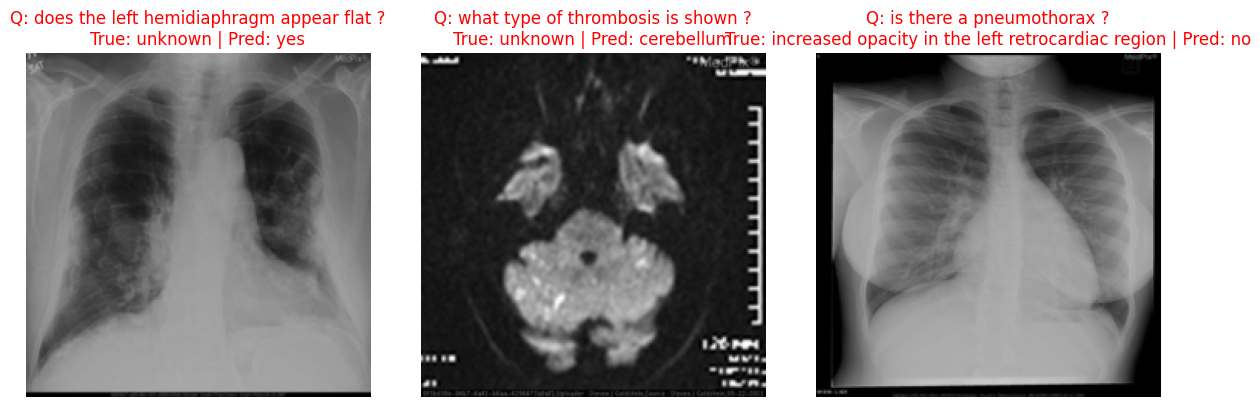

In [10]:
# ==============================================================================
# SECTION 5: EVALUATION & VISUALIZATION
# Purpose: Calculate Accuracy and visualize Predictions.
# ==============================================================================

# =========================================================
# 1. EVALUATION FUNCTION
# =========================================================
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0

    print("🔎 Evaluating...")
    with torch.no_grad():
        for imgs, qs, labels in loader:
            imgs, qs, labels = imgs.to(device), qs.to(device), labels.to(device)

            outputs = model(imgs, qs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"✅ Final Accuracy: {acc:.2f}%")
    return acc

# =========================================================
# 2. SMART WEIGHT LOADER (UPDATED FOR NEW ARCHITECTURE)
# =========================================================
if os.path.exists(MODEL_SAVE_PATH):
    print(f"📂 Found file at {MODEL_SAVE_PATH}. Analyzing structure...")
    checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device)

    # A. Get State Dict & Vocab
    if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
        # We need the Answer Map to decode predictions later
        ans_map = checkpoint.get('answer_to_idx', None)
    else:
        state_dict = checkpoint
        ans_map = None # Should not happen with your file

    # B. Detect SIZES (Questions vs Answers)
    # 1. Answer Vocab (Output Layer)
    if 'classifier.3.weight' in state_dict:
        ans_vocab_size = state_dict['classifier.3.weight'].shape[0]
    else:
        ans_vocab_size = 517 # Fallback

    # 2. Question Vocab (Input Layer)
    if 'embedding.weight' in state_dict:
        ques_vocab_size = state_dict['embedding.weight'].shape[0]
    else:
        ques_vocab_size = 1237 # Fallback

    # 3. Hyperparams
    saved_embed_dim = state_dict['embedding.weight'].shape[1] if 'embedding.weight' in state_dict else 256
    saved_hidden_dim = state_dict['lstm.weight_hh_l0'].shape[1] if 'lstm.weight_hh_l0' in state_dict else 512

    print(f"   -> Detected: Q_Vocab={ques_vocab_size}, A_Vocab={ans_vocab_size}")

    # C. Re-Initialize Model with SPLIT sizes
    model = CNN_LSTM_VQA(
        question_vocab_size=ques_vocab_size,
        answer_vocab_size=ans_vocab_size,
        embed_size=saved_embed_dim,
        hidden_size=saved_hidden_dim
    ).to(device)

    # D. Fix Layer Names
    new_state_dict = {}
    for k, v in state_dict.items():
        new_key = k.replace("vision_encoder", "resnet")
        new_state_dict[new_key] = v

    # E. Load Weights
    try:
        model.load_state_dict(new_state_dict)
        print("✅ Success! Weights loaded correctly.")
    except Exception as e:
        print(f"❌ Error loading weights: {e}")

else:
    print("❌ No saved weights found. Using random initialization.")

# Run Evaluation
evaluate_model(model, dataloader)

# =========================================================
# 3. VISUALIZATION (UPDATED)
# =========================================================
def visualize_predictions(model, dataset, num_samples=3):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    # We need to reverse the Answer Map to decode predictions (0 -> 'yes')
    # If ans_map isn't available, we assume dataset.vocab works (legacy)
    if 'ans_map' in globals() and ans_map is not None:
        idx2ans = {v: k for k, v in ans_map.items()}
    elif hasattr(dataset, 'idx_to_answer'):
        idx2ans = dataset.idx_to_answer
    else:
        idx2ans = dataset.vocab.idx2word # Fallback

    plt.figure(figsize=(12, 4))

    for i, idx in enumerate(indices):
        img, q_tensor, label_tensor = dataset[idx]

        # Predict
        with torch.no_grad():
            output = model(img.unsqueeze(0).to(device), q_tensor.unsqueeze(0).to(device))
            pred_idx = output.argmax(1).item()

        # Decode Text
        # Question: Skip special tokens (0,1,2 usually PAD, SOS, EOS)
        q_tokens = [dataset.vocab.idx2word[t.item()] for t in q_tensor if t.item() not in [0,1,2]]
        q_text = " ".join(q_tokens)

        # Answer: Use the specialized Answer Map
        truth = idx2ans.get(label_tensor.item(), "unknown")
        pred = idx2ans.get(pred_idx, "unknown")

        # Plot
        ax = plt.subplot(1, 3, i+1)
        # Denormalize image
        img_disp = img.permute(1, 2, 0).numpy()
        img_disp = img_disp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

        plt.imshow(np.clip(img_disp, 0, 1))
        plt.title(f"Q: {q_text}\nTrue: {truth} | Pred: {pred}", fontsize=10)
        plt.axis('off')

        if truth == pred:
            ax.set_title(ax.get_title(), color='green', fontweight='bold')
        else:
            ax.set_title(ax.get_title(), color='red')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, dataset)

##FINAL EVALUATION CELL: CNN-LSTM COMPARISON METRICS
To compare with LLaVA-MED model

In [12]:
# ==========================================
# FINAL EVALUATION CELL: CNN-LSTM COMPARISON METRICS
# ==========================================
# 1. Install Metrics Libraries (if not already installed)
!pip install rouge-score nltk sacrebleu
!pip install bert_score

import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score
from tqdm import tqdm
from torchvision import transforms
import os
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')

# =========================================================
# 1. FINAL MODEL ARCHITECTURE
# =========================================================
class CNN_LSTM_VQA(nn.Module):
    def __init__(self, question_vocab_size, answer_vocab_size, embed_size=256, hidden_size=512):
        super(CNN_LSTM_VQA, self).__init__()

        # Visual Encoder
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.vision_linear = nn.Linear(2048, hidden_size)
        self.bn_vision = nn.BatchNorm1d(hidden_size)

        # Text Encoder
        self.embedding = nn.Embedding(question_vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)

        # Classifier (Concatenation Fusion)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, answer_vocab_size)
        )

    def forward(self, images, questions):
        features = self.resnet(images).view(images.size(0), -1)
        img_features = self.bn_vision(self.vision_linear(features))

        embeds = self.embedding(questions)
        _, (hidden, _) = self.lstm(embeds)
        txt_features = hidden[-1]

        combined = torch.cat((img_features, txt_features), dim=1)
        return self.classifier(combined)

# =========================================================
# 2. FINAL EVALUATION FUNCTION (OPEN-ENDED ONLY)
# =========================================================
def evaluate_performance(model_path, json_path, img_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--> Loading model from {model_path}...")

    if not os.path.exists(model_path):
        print("❌ Error: Model file not found.")
        return

    checkpoint = torch.load(model_path, map_location=device)
    state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint

    # --- 1. DETECT SIZES ---
    ans_vocab_size = state_dict['classifier.3.weight'].shape[0] if 'classifier.3.weight' in state_dict else 517
    ques_vocab_size = state_dict['embedding.weight'].shape[0] if 'embedding.weight' in state_dict else 1237
    embed_dim = state_dict['embedding.weight'].shape[1] if 'embedding.weight' in state_dict else 256
    hidden_dim = state_dict['lstm.weight_hh_l0'].shape[1] if 'lstm.weight_hh_l0' in state_dict else 512

    # --- 2. RECOVER & WRAP VOCAB ---
    raw_vocab = checkpoint['vocab']
    ans_map = checkpoint['answer_to_idx']

    # Wrapper fix for compatibility
    vocab_wrapper = lambda x: raw_vocab.get(x, raw_vocab.get('<UNK>', 0))
    vocab_wrapper.word2idx = raw_vocab

    # --- 3. INITIALIZE MODEL ---
    model = CNN_LSTM_VQA(ques_vocab_size, ans_vocab_size, embed_dim, hidden_dim).to(device)
    clean_state_dict = {k.replace("vision_encoder", "resnet"): v for k, v in state_dict.items()}
    model.load_state_dict(clean_state_dict, strict=False)
    print("✅ Model loaded successfully.")

    # --- 4. DATASET SETUP ---
    tfm = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = VQARADDataset(json_path, img_dir, transform=tfm, vocab=vocab_wrapper)
    idx2ans = {v: k for k, v in ans_map.items()}

    # --- 5. INFERENCE LOOP ---
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    smoothie = SmoothingFunction().method4

    open_bleu_scores = []; open_rouge_scores = []
    open_pred_texts = []; open_true_texts = []

    print("\n📝 Generating Qualitative Samples (First 5)...")
    print("-" * 60)

    model.eval()
    count = 0
    printed_samples = 0

    for i in tqdm(range(len(dataset))):
        try:
            # Filter: Only Open-Ended Questions
            row = dataset.data.iloc[i]
            if str(row['answer_type']).upper() != 'OPEN':
                continue

            count += 1
            image, question, _ = dataset[i]

            with torch.no_grad():
                img_batch = image.unsqueeze(0).to(device)
                q_batch = question.unsqueeze(0).to(device)
                output = model(img_batch, q_batch)
                pred_idx = output.argmax(1).item()

            # Decode
            pred_text = idx2ans.get(pred_idx, "unknown")
            true_text = str(row['answer']).lower().strip()
            pred_text = str(pred_text).lower().strip()

            # Print Qualitative Samples (First 5)
            if printed_samples < 5:
                print(f"Q: {row['question']}")
                print(f"   Model: {pred_text}  |  Truth: {true_text}")
                print("-" * 60)
                printed_samples += 1

            # Metrics
            bleu = sentence_bleu([true_text.split()], pred_text.split(), smoothing_function=smoothie)
            open_bleu_scores.append(bleu)
            rouge = scorer.score(true_text, pred_text)['rougeL'].fmeasure
            open_rouge_scores.append(rouge)
            open_pred_texts.append(pred_text)
            open_true_texts.append(true_text)

        except Exception as e:
            continue

    # --- 6. BIAS CHECK ---
    print(f"\n📊 Prediction Distribution (Total Open Qs: {count})")
    if open_pred_texts:
        pred_series = pd.Series(open_pred_texts)
        top_5 = pred_series.value_counts().head(5)
        print("Most frequent predictions:")
        print(top_5.to_string())

    # --- 7. BERTSCORE ---
    print(f"\n--> Calculating BERTScore...")
    bert_f1 = 0
    if open_pred_texts:
        P, R, F1 = score(open_pred_texts, open_true_texts, lang="en", verbose=False)
        bert_f1 = F1.mean().item()

    # --- 8. FINAL REPORT ---
    print(f"\n=== FINAL CNN-LSTM PERFORMANCE (OPEN-ENDED) ===")
    print(f"BLEU-1:         {np.mean(open_bleu_scores):.4f}")
    print(f"ROUGE-L:        {np.mean(open_rouge_scores):.4f}")
    print(f"BERTScore F1:   {bert_f1:.4f}")

    # Save Results
    results = {
        "Model": ["CNN-LSTM Baseline"],
        "BLEU-1": [f"{np.mean(open_bleu_scores):.4f}"],
        "ROUGE-L": [f"{np.mean(open_rouge_scores):.4f}"],
        "BERTScore F1": [f"{bert_f1:.4f}"]
    }
    pd.DataFrame(results).to_csv("cnn_lstm_open_metrics.csv", index=False)
    print("[Saved] Results saved to 'cnn_lstm_open_metrics.csv'")

# RUN EVALUATION
DRIVE_FOLDER = "/content/drive/MyDrive/AML_FinalProject"
evaluate_performance(
    model_path=f"{DRIVE_FOLDER}/cnn_lstm_vqa.pth",
    json_path=f"{DRIVE_FOLDER}/VQA_RAD Dataset Public.json",
    img_dir=f"{DRIVE_FOLDER}/VQA_RAD Image Folder"
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


--> Loading model from /content/drive/MyDrive/AML_FinalProject/cnn_lstm_vqa.pth...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model loaded successfully.

📝 Generating Qualitative Samples (First 5)...
------------------------------------------------------------


  1%|          | 15/2248 [00:00<00:16, 131.68it/s]

Q: What type of imaging does this not represent?
   Model: right  |  Truth: ultrasound
------------------------------------------------------------
Q: What is not pictured in this image?
   Model: right  |  Truth: the extremities
------------------------------------------------------------
Q: Where is the abnormality?
   Model: axial  |  Truth: left temporal lobe
------------------------------------------------------------
Q: Which organ system is abnormal in this image?
   Model: chest x-ray  |  Truth: cardiovascular
------------------------------------------------------------
Q: Where is the pathology in this image?
   Model: the brain  |  Truth: vasculature
------------------------------------------------------------


100%|██████████| 2248/2248 [00:18<00:00, 124.76it/s]



📊 Prediction Distribution (Total Open Qs: 949)
Most frequent predictions:
axial    81
right    50
pa       31
ct       27
yes      23

--> Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== FINAL CNN-LSTM PERFORMANCE (OPEN-ENDED) ===
BLEU-1:         0.2834
ROUGE-L:        0.3973
BERTScore F1:   0.8934
[Saved] Results saved to 'cnn_lstm_open_metrics.csv'
